In [2]:
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers
from keras.utils.vis_utils import plot_model

import tensorflow as tf
import tempfile
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

Sample code

In [3]:
# load model files
model1 = '/content/drive/MyDrive/Project/models/sunglasses_bd_net.h5'
model2 = '/content/drive/MyDrive/Project/models/sunglasses_bd_weights.h5'
model3 = '/content/drive/MyDrive/Project/models/anonymous_bd_net.h5'
model4 = '/content/drive/MyDrive/Project/models/anonymous_bd_weights.h5'
model5 = '/content/drive/MyDrive/Project/models/multi_trigger_multi_target_bd_net.h5'
model6 = '/content/drive/MyDrive/Project/models/multi_trigger_multi_target_bd_weights.h5'

In [4]:
# load data files
clean_test_data = '/content/drive/MyDrive/Project/data/clean_test_data.h5'
clean_val_data = '/content/drive/MyDrive/Project/data/clean_validation_data.h5'
sunglass_data = '/content/drive/MyDrive/Project/data/sunglasses_poisoned_data.h5'
eyebrows_data = '/content/drive/MyDrive/Project/data/eyebrows_poisoned_data.h5'

x_test_c, y_test_c = data_loader(clean_test_data)   # load the clean data
x_val_c, y_val_c = data_loader(clean_val_data)
x_sunglass, y_sunglass = data_loader(sunglass_data)
x_eye, y_eye = data_loader(eyebrows_data)

x_test_c = data_preprocess(x_test_c)
x_val_c = data_preprocess(x_val_c)
x_sunglass = data_preprocess(x_sunglass)
x_eye = data_preprocess(x_eye)

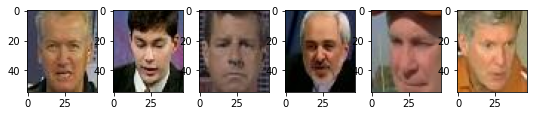

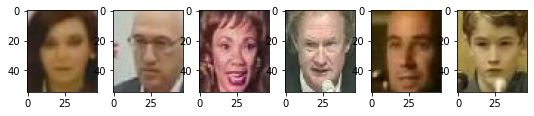

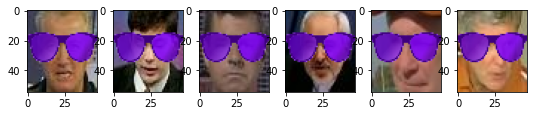

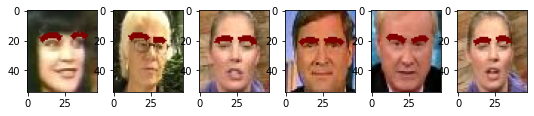

In [ ]:
# plot some sample images from the dataset
plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_test_c[id])  

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_val_c[id]) 

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_sunglass[id]) 

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(x_eye[id]) 

In [ ]:
def Net():         # the architecture of deepid net
	# define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat)
	# summarize layers
	#print(model.summary())
	# plot graph
	#plot_model(model, to_file='model_architecture.png')

	return model

K.clear_session()
model = Net()
#model.save('/content/drive/MyDrive/Project/models/deepid_net.h5') # save the model to my drive

##Train the DeepID net above using clean validation dataset

In [ ]:
# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

In [ ]:
# training
model.fit(x_val_c, y_val_c, epochs=15)

Epoch 1/15
361/361 [==============================] - 9s 4ms/step - loss: 7.1617 - accuracy: 4.0819e-05
Epoch 2/15
361/361 [==============================] - 1s 4ms/step - loss: 7.0232 - accuracy: 0.0055
Epoch 3/15
361/361 [==============================] - 1s 4ms/step - loss: 4.9025 - accuracy: 0.1586
Epoch 4/15
361/361 [==============================] - 1s 4ms/step - loss: 2.7958 - accuracy: 0.4698
Epoch 5/15
361/361 [==============================] - 1s 4ms/step - loss: 1.6559 - accuracy: 0.6607
Epoch 6/15
361/361 [==============================] - 1s 4ms/step - loss: 1.0497 - accuracy: 0.7735
Epoch 7/15
361/361 [==============================] - 1s 4ms/step - loss: 0.6720 - accuracy: 0.8464
Epoch 8/15
361/361 [==============================] - 1s 4ms/step - loss: 0.3898 - accuracy: 0.9075
Epoch 9/15
361/361 [==============================] - 1s 4ms/step - loss: 0.2630 - accuracy: 0.9310
Epoch 10/15
361/361 [==============================] - 1s 4ms/step - loss: 0.1556 - accuracy: 0.

In [ ]:
# test
clean_label_p = np.argmax(model.predict(x_test_c), axis=1)
poisoned_label_p = np.argmax(model.predict(x_sunglass), axis=1)
class_accu_c = np.mean(np.equal(clean_label_p, y_test_c))*100
class_accu_p = np.mean(np.equal(poisoned_label_p, y_sunglass))*100
print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
print('Classification accuracy for poisoned inputs: {:.2f}%'.format(class_accu_p))
model.save('/content/drive/MyDrive/Project/models/deepid_net.h5')

Classification accuracy for clean inputs: 74.96%
Classification accuracy for poisoned inputs: 0.00%


We can see that the classification accuracy for poisoned data has dropped to 0, but the accuracy for clean inputs is around 70%, which is not very high.

Retrain the deepID net, in this case we add another class which correspond to the poisoned inputs.

In [ ]:
labels = list(set(y_val_c))
print(len(labels))

1283


Clean inputs has 1283 classes, so we add another class 1284 for the poisoned inputs.

## Prune the sunglasses badnet

In [5]:
def valid(model, x_test_c, x_test_p, y_test_c, y_test_p):
  print(model.name)
  clean_label_p = np.argmax(model.predict(x_test_c), axis=1)
  poisoned_label_p = np.argmax(model.predict(x_test_p), axis=1)
  class_accu_c = np.mean(np.equal(clean_label_p, y_test_c))*100
  class_accu_p = np.mean(np.equal(poisoned_label_p, y_test_p))*100
  print('Classification accuracy for clean inputs: {:.2f}%'.format(class_accu_c))
  print('Classification accuracy for poisoned inputs: {:.2f}%'.format(class_accu_p))

In [ ]:
sunglass_model = keras.models.load_model(model1)
print('Classification accuracy before pruning:')
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

Classification accuracy before pruning:
model_1
Classification accuracy for clean inputs: 97.78%
Classification accuracy for poisoned inputs: 99.99%


In [ ]:
sunglass_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

print the result of convolution layers under clean data and sunglassed data, sort the weights in the results.

In [ ]:
conv_1 = Model(inputs=sunglass_model.input,
            outputs=sunglass_model.get_layer("conv_1").output)

conv_1_clean_output = np.mean(conv_1.predict(x_val_c), axis=0)
conv_1_poison_output = np.mean(conv_1.predict(x_sunglass), axis=0)

idx_clean = np.argsort(np.sum(conv_1_clean_output, axis=(0, 1)))
idx_poison = np.argsort(np.sum(conv_1_poison_output, axis=(0, 1)))
print(idx_clean)
print(idx_poison)

[19 16  8  6  0 13 15  4 18  9  5 12 11 14  2 17 10  7  1  3]
[19 16  0 15  6  4  8 18  9 13 11 14 12  2  5 10 17  7  1  3]


In [ ]:
conv_2 = Model(inputs=sunglass_model.input,
            outputs=sunglass_model.get_layer("conv_2").output)

conv_2_clean_output = np.mean(conv_2.predict(x_val_c), axis=0)
conv_2_poison_output = np.mean(conv_2.predict(x_sunglass), axis=0)

idx_clean = np.argsort(np.sum(conv_2_clean_output, axis=(0, 1)))
idx_poison = np.argsort(np.sum(conv_2_poison_output, axis=(0, 1)))
print(idx_clean)
print(idx_poison)

[26  4 32 18 38 16 13 20 21 24 11  3 31 34 12  2  6 15 19 17  8 27 39 36
 29  1 28 33 35 22  0 37  9 25 30 10  7 14  5 23]
[26  4 32 16 18 21 24  3 20 38 34 31 13  6  2 12 11 15 17 28  8  1 33 19
 27 36 22 39 29  0 35 37  9 30  7 25 10 14  5 23]


In [ ]:
conv_3 = Model(inputs=sunglass_model.input,
            outputs=sunglass_model.get_layer("conv_3").output)

conv_3_clean_output = np.mean(conv_3.predict(x_val_c), axis=0)
conv_3_poison_output = np.mean(conv_3.predict(x_sunglass), axis=0)

idx_clean = np.argsort(np.sum(conv_3_clean_output, axis=(0, 1)))
idx_poison = np.argsort(np.sum(conv_3_poison_output, axis=(0, 1)))
print(idx_clean)
print(idx_poison)

[32 49 44 12 34 31 37 36  0 57 14 42 58  2  1 26 28 52  8 33 59 47 48  9
 16 10 27 24 23 50 15 13 45 21 43 51 53 20 17 46  3 11 41 19  5 30 25 40
 55  7  4 56 29 38 18 39 22  6 35 54]
[32 49 44 37 34 36 31 12 14 33 42  0  2  8  1 50 48  9 47  3 23 58 16 15
 11 57 28 41 43 24 55 35 52 26 29 40 53 59 19 46 25 56  4 10 17 45 30 39
 20  7 27 18 22  6 38 51 13  5 21 54]


In [ ]:
conv_4 = Model(inputs=sunglass_model.input,
            outputs=sunglass_model.get_layer("conv_4").output)

conv_4_clean_output = np.mean(conv_4.predict(x_val_c), axis=0)
conv_4_poison_output = np.mean(conv_4.predict(x_sunglass), axis=0)

idx_clean = np.argsort(np.sum(conv_4_clean_output, axis=(0, 1)))
idx_poison = np.argsort(np.sum(conv_4_poison_output, axis=(0, 1)))
print(idx_clean)
print(idx_poison)

[20 68  5 36 33 22  9 23 70 27 62 32 50 52 24  1 35 44 12 14 21 67 59  4
  7  2 73 18 45 61 16 65 71 66 43 76 51 39 49 34 75 38 17 29  8 78 26 58
 60 54  3 46 28 64 10 55 47 69 25 57 19 77 48 31 79 13 42 37 30 74 41 72
 15 63 11 53  6  0 56 40]
[20 68 33 27  5 52 12 62 32 24 58 71  9 22 70  2 44 21 69 51 38 29 34 36
  7 28 37 45 61 46 65 23 26 66  4 50  1 77 57 59 39 73 54 48 18 63 17 35
 75  3 16 55 14 43  0 31 47 72 11 25 15 49 67 60 64 30  8 41 76 78 42 10
 79 40 74 19  6 53 56 13]


Prune some neurons that is activated in the poisoned data but is not activated in the clean data.

Enhance the neurons that is activated in clean data but is not activated in poisoned data.

such as prune the 21, 13, 5, 51, 20, 27, 10 neurons and enhance 35, 39, 29, 56, 4, 55, 40, 41, 11, 3 neurons for conv_3 layer

In [ ]:
# prune layer 'conv_1'
sunglass_model = keras.models.load_model(model1)
layer = sunglass_model.get_layer("conv_1")
weight, bias = layer.get_weights()
idx = [5, 13, 8]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

layer.set_weights([weight, bias])
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model_1
Classification accuracy for clean inputs: 97.76%
Classification accuracy for poisoned inputs: 99.91%


In [ ]:
# prune layer 'conv_2'
layer = sunglass_model.get_layer("conv_2")
weight, bias = layer.get_weights()
idx = [29, 39, 19]
idx_c = [33, 28, 1]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

# enhance the clean functionality
for i in range(len(idx_c)):
  cur_idx = idx_c[i]
  for i in range(len(weight[:, :, :, cur_idx])):
    for j in range(len(weight[:, :, :, cur_idx][i])):
      for k in range(len(weight[:, :, :, cur_idx][i][j])):
        if weight[:, :, :, cur_idx][i][j][k]>0 and weight[:, :, :, cur_idx][i][j][k]<0.1:
          weight[:, :, :, cur_idx][i][j][k] = 0.1
  #bias[cur_idx] = 0.1

layer.set_weights([weight, bias])
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model_1
Classification accuracy for clean inputs: 95.04%
Classification accuracy for poisoned inputs: 96.78%


In [ ]:
# prune layer 'conv_3'
layer = sunglass_model.get_layer("conv_3")
weight, bias = layer.get_weights()
idx = [21, 13, 5, 51, 20, 27, 45, 17, 10]
idx_c = [35, 39, 29, 56, 4, 55, 40, 41, 11, 3]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

for i in range(len(idx_c)):
  cur_idx = idx_c[i]
  for i in range(len(weight[:, :, :, cur_idx])):
    for j in range(len(weight[:, :, :, cur_idx][i])):
      for k in range(len(weight[:, :, :, cur_idx][i][j])):
        if weight[:, :, :, cur_idx][i][j][k]>0 and weight[:, :, :, cur_idx][i][j][k]<0.06:
          weight[:, :, :, cur_idx][i][j][k] = 0.06
  #bias[cur_idx] = 0.1

layer.set_weights([weight, bias])
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model_1
Classification accuracy for clean inputs: 76.20%
Classification accuracy for poisoned inputs: 74.89%


In [ ]:
# prune layer 'conv_4'
layer = sunglass_model.get_layer("conv_4")
weight, bias = layer.get_weights()
idx = [13, 79, 64, 19, 10, 75, 6, 53, 60, 42, 8, 1, 76, 30, 56, 78]
idx_c = [0, 11, 63, 15, 72, 37, 48, 77, 57, 69, 28, 46, 58, 29]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

for i in range(len(idx_c)):
  cur_idx = idx_c[i]
  for i in range(len(weight[:, :, :, cur_idx])):
    for j in range(len(weight[:, :, :, cur_idx][i])):
      for k in range(len(weight[:, :, :, cur_idx][i][j])):
        if weight[:, :, :, cur_idx][i][j][k]>0 and weight[:, :, :, cur_idx][i][j][k]<0.04:
          weight[:, :, :, cur_idx][i][j][k] = 0.04
  #bias[cur_idx] = 0.1

layer.set_weights([weight, bias])
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model_1
Classification accuracy for clean inputs: 62.35%
Classification accuracy for poisoned inputs: 34.14%


The result shows that the accuracy for both clean inputs and poisoned inputs have decreased. Although the accuracy for poisoned inputs become much lower, but the accuracy for clean inputs also decrease from a hign level.

Now let's retrain the pruned model using the validation data and test the performance. 

In [ ]:
# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

sunglass_model.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

# retraining
sunglass_model.fit(x_val_c, y_val_c, epochs=8)

Epoch 1/8
361/361 [==============================] - 2s 4ms/step - loss: 1.3986 - accuracy: 0.7504
Epoch 2/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1926 - accuracy: 0.9567
Epoch 3/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1726 - accuracy: 0.9549
Epoch 4/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1348 - accuracy: 0.9627
Epoch 5/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1575 - accuracy: 0.9574
Epoch 6/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1006 - accuracy: 0.9707
Epoch 7/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1191 - accuracy: 0.9676
Epoch 8/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1076 - accuracy: 0.9691


In [ ]:
valid(sunglass_model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model_1
Classification accuracy for clean inputs: 86.84%
Classification accuracy for poisoned inputs: 0.79%


Now we can see the accuracy of clean inputs is high.

In [ ]:
sunglass_model.save('/content/drive/MyDrive/Project/models/sunglass_model_repaired.h5')

Let's test that if we only enhance neurons for clean inputs in the clean net, and whether will the prediction result improve.

In [ ]:
# prune layer 'conv_2'
model = keras.models.load_model('/content/drive/MyDrive/Project/models/deepid_net.h5')
layer = model.get_layer("conv_2")
weight, bias = layer.get_weights()
idx_c = [0, 37, 9, 25, 30, 10, 7, 14, 5, 23]
#idx_c = [33, 28, 1]

# enhance the clean functionality
for i in range(len(idx_c)):
  cur_idx = idx_c[i]
  for i in range(len(weight[:, :, :, cur_idx])):
    for j in range(len(weight[:, :, :, cur_idx][i])):
      for k in range(len(weight[:, :, :, cur_idx][i][j])):
        if weight[:, :, :, cur_idx][i][j][k]>0 and weight[:, :, :, cur_idx][i][j][k]<0.1:
          weight[:, :, :, cur_idx][i][j][k] = 0.1
  #bias[cur_idx] = 0.1

layer.set_weights([weight, bias])
valid(model, x_test_c, x_sunglass, y_test_c, y_sunglass)

model
Classification accuracy for clean inputs: 57.05%
Classification accuracy for poisoned inputs: 0.00%


The result even decrease after enhancing.

## Anonymous badnet

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Project/models/deepid_net.h5')
anon_model = keras.models.load_model(model3)
valid(anon_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 96.01%
Classification accuracy for poisoned inputs: 91.35%


In [ ]:
layer = model.get_layer("conv_1")
weight_c, bias_c = layer.get_weights()
layer = anon_model.get_layer("conv_1")
weight_p, bias_p = layer.get_weights()

idx_clean = np.argsort(np.sum(np.clip(weight_c, 0, 1000), axis=(0, 1, 2)))
idx_poison = np.argsort(np.sum(np.clip(weight_p, 0, 1000), axis=(0, 1, 2)))
print(idx_clean)
print(idx_poison)

[ 0 11  4  5  8  6  3  2 15 19  7 14 13 16  9 12 18 17  1 10]
[ 8 18  4  5  9  3 14 11 15 13  0  6 12  2  1  7 19 10 16 17]


17, 16, 10, 7, 2, 12

In [ ]:
layer = model.get_layer("conv_2")
weight_c, bias_c = layer.get_weights()
layer = anon_model.get_layer("conv_2")
weight_p, bias_p = layer.get_weights()

idx_clean = np.argsort(np.sum(np.clip(weight_c, 0, 1000), axis=(0, 1, 2)))
idx_poison = np.argsort(np.sum(np.clip(weight_p, 0, 1000), axis=(0, 1, 2)))
print(idx_clean)
print(idx_poison)

[19  9 25 38 29  2 28 31 18  0 20 30 15 17  1 21  6 39  8 22 11 36  4 16
 26 32  7 35  3 12 27 37 10 23 13 33 24 14 34  5]
[29  4 15 22 11  8 23  0 16 34 33 10  1 30 28 18 36 21  9 32 38 24 12 19
 39 25  2  5 17 31  3  7 13  6 37 14 27 35 26 20]


0,36, 30, 22, 10, 15, 28, 11, 8, 29

idx = [26, 35, 7, 6, 0, 14, 27, 5, 32]

In [ ]:
# prune layer 'conv_1'
anon_model = keras.models.load_model(model3)
layer = anon_model.get_layer("conv_1")
weight, bias = layer.get_weights()
idx = [14,9,11,4,8]
idx_c = [19, 18, 2, 9]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

layer.set_weights([weight, bias])
valid(anon_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 95.96%
Classification accuracy for poisoned inputs: 89.73%


In [ ]:
# prune layer 'conv_2'
layer = anon_model.get_layer("conv_2")
weight, bias = layer.get_weights()
idx = [14, 27, 35, 26]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

layer.set_weights([weight, bias])
valid(anon_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 94.72%
Classification accuracy for poisoned inputs: 86.36%


In [ ]:
# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

anon_model.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

# retraining
anon_model.fit(x_val_c, y_val_c, epochs=8)

Epoch 1/8
361/361 [==============================] - 2s 4ms/step - loss: 0.5550 - accuracy: 0.8778
Epoch 2/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0847 - accuracy: 0.9752
Epoch 3/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0805 - accuracy: 0.9774
Epoch 4/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0864 - accuracy: 0.9756
Epoch 5/8
361/361 [==============================] - 1s 4ms/step - loss: 0.1065 - accuracy: 0.9673
Epoch 6/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0883 - accuracy: 0.9732
Epoch 7/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9791
Epoch 8/8
361/361 [==============================] - 1s 4ms/step - loss: 0.0575 - accuracy: 0.9855


In [ ]:
valid(anon_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 89.62%
Classification accuracy for poisoned inputs: 0.46%


In [ ]:
anon_model.save('/content/drive/MyDrive/Project/models/anon_model_repaired.h5')

## Multi-trigger badnet

In [27]:
model = keras.models.load_model('/content/drive/MyDrive/Project/models/deepid_net.h5')
multi_model = keras.models.load_model(model5)
valid(multi_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 96.01%
Classification accuracy for poisoned inputs: 91.35%


In [8]:
layer = model.get_layer("conv_1")
weight_c, bias_c = layer.get_weights()
layer = multi_model.get_layer("conv_1")
weight_p, bias_p = layer.get_weights()

idx_clean = np.argsort(np.sum(np.clip(weight_c, 0, 1000), axis=(0, 1, 2)))
idx_poison = np.argsort(np.sum(np.clip(weight_p, 0, 1000), axis=(0, 1, 2)))
print(idx_clean)
print(idx_poison)

[ 0 11  4  5  8  6  3  2 15 19  7 14 13 16  9 12 18 17  1 10]
[ 8 18  4  5  9  3 14 11 15 13  0  6 12  2  1  7 19 10 16 17]


16, 19, 2, 0

In [10]:
layer = model.get_layer("conv_2")
weight_c, bias_c = layer.get_weights()
layer = multi_model.get_layer("conv_2")
weight_p, bias_p = layer.get_weights()

idx_clean = np.argsort(np.sum(np.clip(weight_c, 0, 1000), axis=(0, 1, 2)))
idx_poison = np.argsort(np.sum(np.clip(weight_p, 0, 1000), axis=(0, 1, 2)))
print(idx_clean)
print(idx_poison)

[19  9 25 38 29  2 28 31 18  0 20 30 15 17  1 21  6 39  8 22 11 36  4 16
 26 32  7 35  3 12 27 37 10 23 13 33 24 14 34  5]
[29  4 15 22 11  8 23  0 16 34 33 10  1 30 28 18 36 21  9 32 38 24 12 19
 39 25  2  5 17 31  3  7 13  6 37 14 27 35 26 20]


20, 26, 6, 31, 17, 2, 25, 19

In [28]:
layer = model.get_layer("conv_3")
weight_c, bias_c = layer.get_weights()
layer = multi_model.get_layer("conv_3")
weight_p, bias_p = layer.get_weights()

idx_clean = np.argsort(np.sum(np.clip(weight_c, 0, 1000), axis=(0, 1, 2)))
idx_poison = np.argsort(np.sum(np.clip(weight_p, 0, 1000), axis=(0, 1, 2)))
print(idx_clean)
print(idx_poison)

[47 40 16 10 42 30 32 55 44  2 29  9 38 54  7 24  6 19  5 33 28 56 43 21
 36  1 14  8 41 31 23 18 49 22 25 57 15 34 48 51 53 13 11 58 27 52 26 45
 35 50 46  0 37  4 59 39 17  3 12 20]
[32 26 43 58 33 22 18 17 53 57 49 19 15 16 20 41 51 10 52 29 30  7  6 12
 40 55 44  1 50 37  8 31  0 59 21 54 42  3 24 34  9 13 14 36  4 46 27 11
 47 45 23 48 28 35 25 39  5  2 38 56]


56, 38, 2, 5, 28, 23, 47, 9

In [10]:
# prune layer 'conv_1'
multi_model = keras.models.load_model(model5)
layer = multi_model.get_layer("conv_1")
weight, bias = layer.get_weights()
idx = [8, 18, 4, 5, 9, 3, 14]

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

layer.set_weights([weight, bias])
valid(multi_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 95.97%
Classification accuracy for poisoned inputs: 89.21%


In [11]:
# prune layer 'conv_2'
layer = multi_model.get_layer("conv_2")
weight, bias = layer.get_weights()
idx = [20, 26, 6, 31, 17, 2, 25, 19] 

for i in range(len(idx)):
  cur_idx = idx[i]
  weight[:, :, :, cur_idx] = 0
  bias[cur_idx] = 0

layer.set_weights([weight, bias])
valid(multi_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 92.31%
Classification accuracy for poisoned inputs: 75.66%


In [12]:
# define the loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

multi_model.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

# retraining
multi_model.fit(x_val_c, y_val_c, epochs=10)

Epoch 1/10
361/361 [==============================] - 2s 4ms/step - loss: 0.5187 - accuracy: 0.8822
Epoch 2/10
361/361 [==============================] - 1s 4ms/step - loss: 0.1015 - accuracy: 0.9756
Epoch 3/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0917 - accuracy: 0.9760
Epoch 4/10
361/361 [==============================] - 1s 4ms/step - loss: 0.1017 - accuracy: 0.9752
Epoch 5/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0913 - accuracy: 0.9735
Epoch 6/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0636 - accuracy: 0.9851
Epoch 7/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0820 - accuracy: 0.9808
Epoch 8/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0647 - accuracy: 0.9818
Epoch 9/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0790 - accuracy: 0.9794
Epoch 10/10
361/361 [==============================] - 1s 4ms/step - loss: 0.0453 - accuracy: 0.9877

In [13]:
valid(multi_model, x_test_c, x_eye, y_test_c, y_eye)

model_1
Classification accuracy for clean inputs: 87.37%
Classification accuracy for poisoned inputs: 0.45%


In [14]:
multi_model.save('/content/drive/MyDrive/Project/models/multi_model_repaired.h5')